# Eval the results of falcon 7b

In [191]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import f1_score, precision_score, recall_score, \
    accuracy_score

import re
from typing import List, Tuple

import pandas as pd


def is_contained(inner_start, inner_end, outer_start, outer_end):
    return (
        outer_start <= inner_start <= outer_end
        and outer_start <= inner_end <= outer_end
        and (inner_start, inner_end) != (outer_start, outer_end)
    )


def find_all_occurrences_indices(
    sentence: str,
    label: str,
) -> List[Tuple[int, int]]:
    """
    Finds all occurrences of a label in a sentence and returns a list of tuples
    with the start and end indices of the occurrences.

    Args:
        sentence: The sentence to search in.
        label: The label to search for.

    Returns:
        A list of tuples with the start and end indices of the occurrences.
    """
    return [
        (int(match.start()), int(match.end()))
        for match in re.finditer(label, sentence)
    ]


def find_contained_labels(labels):
    """
    Finds all labels that are contained in other labels.

    Args:
        labels: A list of labels.

    Returns:
        A dictionary with the labels as keys and a list of labels that are
        contained in the key label as values.
    """
    return {
        label_1: [
            label2
            for label2 in labels
            if label_1 in label2 and label_1 != label2
        ]
        for label_1 in labels
    }


def find_labels_in_sentence(
    sentence: str,
    labels: List[str],
) -> List[List[Tuple[int, int]]]:
    """
    Finds all occurrences of the labels in a sentence and returns a list of
    lists with the occurrences of each label.

    Labels that are contained in other labels are not returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.

    Returns:
        A list of lists with the positional occurrence of each label.
    """
    if not labels:
        return []

    containable_map = find_contained_labels(labels)
    sentence_lower = sentence.lower()
    occurrences = [
        find_all_occurrences_indices(sentence_lower, label.lower())
        for label in labels
    ]
    label_occurrences = dict(zip(labels, occurrences))
    included_list = []
    for label, inner_pos in zip(labels, occurrences):
        contained = set()
        containing_labels = containable_map.get(label, set())

        for bigger_label in containing_labels:
            locations: List[Tuple[int, int]] = label_occurrences.get(
                bigger_label,
                list(),
            )

            for inner_start, inner_end in inner_pos:
                for outer_start, outer_end in locations:
                    if is_contained(
                        inner_start,
                        inner_end,
                        outer_start,
                        outer_end,
                    ):
                        contained.add((inner_start, inner_end))
        included_list.append(list(contained))

    return [
        list(set(pos) - set(included))
        for pos, included in zip(occurrences, included_list)
    ]


def find_label(
    sentence: str,
    labels: List[str],
    default_label: str = "?",
) -> str:
    """
    Search for given labels in the sentence and returns it if found. If only
    one label occur in the sentence, it will be returned. If no label or
    different labels occur in the sentence, '?' is returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.
        default_label: The label to return if no label or different labels
            occur in the sentence.

    Returns:
        The label that occurs in the sentence or '?' if no label occurs in the
        sentence.
    """
    occurrences = find_labels_in_sentence(sentence=sentence, labels=labels)
    non_empty_indices = [i for i, sublist in enumerate(occurrences) if sublist]
    return (
        labels[non_empty_indices[0]]
        if len(
            non_empty_indices,
        )
           == 1
        else default_label
    )


def _soft_parse(
    df: pd.DataFrame,
    in_col: str,
    parsed_col: str,
    labels: List[str] = None,
) -> pd.DataFrame:
    if labels is None:
        raise ValueError("Labels are not set!")

    df[parsed_col] = df[in_col].apply(
        lambda x: find_label(x, labels),
    )


In [192]:

# load
model = 'falcon-7b-instruct'

# load results
zero_shot = pd.read_csv(f"../zero-shot/data/{model}.csv")
zero_shot_with_system = pd.read_csv(
    f"../zero-shot-system_prompt/data/{model}.csv")
zero_shot_cot = pd.read_csv(f"../zero-shot-cot/data/{model}.csv")
two_shot = pd.read_csv(f"../2-shot/data/{model}.csv")
four_shot = pd.read_csv(f"../4-shot/data/{model}.csv")
eight_shot = pd.read_csv(f"../8-shot/data/{model}.csv")

two_shot_cot = pd.read_csv(f"../2-shot-CoT/data/{model}.csv")
four_shot_cot = pd.read_csv(f"../4-shot-CoT/data/{model}.csv")
eight_shot_cot = pd.read_csv(f"../8-shot-CoT/data/{model}.csv")

#load pool
pool = load_dataset('mediabiasgroup/BABE-icl-pool')['train'].to_pandas()

# exclude pool from model (if needed)
zero_shot = zero_shot.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
zero_shot_with_system = zero_shot_with_system.merge(pool['text'], on='text',
                                                    how='left',
                                                    indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
zero_shot_cot = zero_shot_cot.merge(pool['text'], on='text', how='left',
                                    indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
two_shot = two_shot.merge(pool['text'], on='text', how='left',
                          indicator=True).query('_merge == "left_only"').drop(
    '_merge', axis=1)
four_shot = four_shot.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
eight_shot = eight_shot.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
two_shot_cot = two_shot_cot.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
four_shot_cot = four_shot_cot.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
eight_shot_cot = eight_shot_cot.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)


#load babe
dataset = load_dataset('mediabiasgroup/BABE-v4')
df_babe = pd.DataFrame(dataset['train'])

# df_merge = babe at begin
df_merge_all_runs = df_babe
df_merge_all_runs_with_errors = df_babe

def find_first_occurrence(string, instruction="Instruction:",
                          statement1="The answer is BIASED",
                          statement2="The answer is NOT BIASED"
                          ):
    index_instruction = string.find(instruction)
    index1 = string.find(statement1)
    index2 = string.find(statement2)

    if index1 == -1 and index2 == -1:
        return "Neither instruction nor statements found in the given string."
    elif index1 == -1 and index2 == -1:
        return "Neither statement found in the given string."
    elif index1 == -1:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"
    elif index2 == -1:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    elif index1 < index2:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    else:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"


# Zero shot

In [193]:
_soft_parse(zero_shot, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
zero_shot.query("label == '?'")

,text,response,raw_data,query,label
10,"And, of course, along the way, the hipster CEO...",'NOT BIASED'\n\nExplanation: The sentence port...,"Instruction: 'And, of course, along the way, t...","Instruction: 'And, of course, along the way, t...",?
36,"Since the incident, the mainstream media — in ...",'NOT BIASED'\n\nExplanation: The sentence is n...,"Instruction: 'Since the incident, the mainstre...","Instruction: 'Since the incident, the mainstre...",?
51,As leading 2020 Dems advocate spending big on ...,'NOT BIASED'\n\nExplanation: The sentence does...,Instruction: 'As leading 2020 Dems advocate sp...,Instruction: 'As leading 2020 Dems advocate sp...,?
211,His confidence in his sense of humor is the sa...,'NOT BIASED'\n\nExplanation: The sentence is n...,Instruction: 'His confidence in his sense of h...,Instruction: 'His confidence in his sense of h...,?
258,Father Horan was one of the many voices from t...,'NOT BIASED'\n\nExplanation: The sentence is n...,Instruction: 'Father Horan was one of the many...,Instruction: 'Father Horan was one of the many...,?
...,...,...,...,...,...
3588,Wealthy American corporations are using their ...,'NOT BIASED'\n\nExplanation: The sentence pres...,Instruction: 'Wealthy American corporations ar...,Instruction: 'Wealthy American corporations ar...,?
3618,While falling short of calling half the nation...,'NOT BIASED'\n\nExplanation: The sentence is n...,Instruction: 'While falling short of calling h...,Instruction: 'While falling short of calling h...,?
3812,Chicago Police Superintendent David Brown desc...,'NOT BIASED'\n\nExplanation: The sentence desc...,Instruction: 'Chicago Police Superintendent Da...,Instruction: 'Chicago Police Superintendent Da...,?
3872,It's not immediately clear what Biden was tryi...,'Not Biased'\n\nExplanation: The sentence is n...,Instruction: 'It's not immediately clear what ...,Instruction: 'It's not immediately clear what ...,?


In [194]:
# preprocessing
# preprocessing
def update_label(row):
    if row['response'].startswith("'BIASED'") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("'Biased'") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("1") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("'NOT BIASED'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("'Not BIASED'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("'Not Biased'") and row[
        'label'] == '?':
        return 'NOT BIASED'

    else:
        return row['label']


zero_shot['label'] = zero_shot.apply(update_label, axis=1)
zero_shot.query("label == '?'")

,text,response,raw_data,query,label


In [195]:
zero_shot = zero_shot.rename(columns={"label": "0_shot_label"})
zero_shot['0_shot_label'] = zero_shot['0_shot_label'].replace('BIASED', 1)
zero_shot['0_shot_label'] = zero_shot['0_shot_label'].replace('NOT BIASED', 0)

df_merge = pd.merge(df_babe, zero_shot[['text', '0_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot[zero_shot['0_shot_label'] != '?'][['text', '0_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(zero_shot[['text', '0_shot_label']], on='text')


ground_truth = df_merge['label']
zero_shot_label = df_merge['0_shot_label']

In [196]:
print("F1-Score with TODO: ", f1_score(ground_truth, zero_shot_label))
print("Precision with TODO: ",
      precision_score(ground_truth, zero_shot_label))
print("Recall with TODO: ",
      recall_score(ground_truth, zero_shot_label))
print("Accuracy with TODO: ",
      accuracy_score(ground_truth, zero_shot_label))

F1-Score with TODO:  0.5398627868464633
Precision with TODO:  0.5102862254025045
Recall with TODO:  0.5730788548468106
Accuracy with TODO:  0.5162894802287988


# zero shot with system prompt

In [197]:
_soft_parse(zero_shot_with_system, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
zero_shot_with_system.query("label == '?'")

,text,response,raw_data,query,label
20,A Joe Biden presidency could reset ties with t...,'NOT BIASED'\n\nExplanation: The sentence pres...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
95,The head of the World Health Organization said...,'NOT BIASED'\n\nExplanation: The sentence does...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
196,With radical feminists and extremist trans act...,'NOT BIASED'\n\nExplanation: The sentence port...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
297,This is why Donald Trump is awake at 2:30 a.m....,'NOT BIASED'\n\nExplanation: The sentence pres...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
383,While the stupid Democrats who vote for Democr...,'NOT BIASED'\n\nExplanation: The sentence cont...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3658,acked by Virginia’s first Democratic-controlle...,'NOT BIASED'\n\nExplanation: The sentence pres...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3837,It amazes me that even intelligent people – in...,'NOT BIASED'\n\nExplanation: The sentence is n...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3845,The movement’s hysteric leader proceeded to hu...,"'Hysteric' (BIASED), 'leader' (NOT BIASED),'mo...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3851,A leading economist who vouched for Democratic...,'NOT BIASED'\n\nExplanation: The sentence pres...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [198]:
# preprocessing
# preprocessing
def update_label(row):
    if row['response'].startswith("'BIASED'") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("'Biased'") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("1") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("'NOT BIASED'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("'Not BIASED'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("'Not Biased'") and row[
        'label'] == '?':
        return 'NOT BIASED'

    else:
        return row['label']


zero_shot_with_system['label'] = zero_shot_with_system.apply(update_label, axis=1)
zero_shot_with_system.query("label == '?'")

,text,response,raw_data,query,label
2062,'Pandemic Apprentice': Deprived of rallies to ...,'Pandemic Apprentice': Deprived of rallies to ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3845,The movement’s hysteric leader proceeded to hu...,"'Hysteric' (BIASED), 'leader' (NOT BIASED),'mo...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [199]:
zero_shot_with_system = zero_shot_with_system.rename(
    columns={"label": "0_shot_with_system_label"})
zero_shot_with_system['0_shot_with_system_label'] = zero_shot_with_system[
    '0_shot_with_system_label'].replace('BIASED', 1)
zero_shot_with_system['0_shot_with_system_label'] = zero_shot_with_system[
    '0_shot_with_system_label'].replace('NOT BIASED', 0)


df_merge = df_babe.merge(zero_shot_with_system[zero_shot_with_system['0_shot_with_system_label'] != '?'], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot_with_system[zero_shot_with_system['0_shot_with_system_label'] != '?'][['text', '0_shot_with_system_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(zero_shot_with_system[['text', '0_shot_with_system_label']], on='text')


ground_truth = df_merge['label'].astype(int)
zero_shot_with_system_label = df_merge['0_shot_with_system_label'].astype(int)

In [200]:
print("F1-Score with TODO with System Prompt: ",
      f1_score(ground_truth, zero_shot_with_system_label))
print("Precision with TODO with System Prompt: ",
      precision_score(ground_truth, zero_shot_with_system_label))
print("Recall with TODO with System Prompt: ",
      recall_score(ground_truth, zero_shot_with_system_label))
print("Accuracy with TODO with System Prompt: ",
      accuracy_score(ground_truth, zero_shot_with_system_label))

F1-Score with TODO with System Prompt:  0.5074925074925075
Precision with TODO with System Prompt:  0.5042183622828784
Recall with TODO with System Prompt:  0.5108094519859225
Accuracy with TODO with System Prompt:  0.5093306792734511


# zero shot CoT

In [201]:
zero_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
4,Republican state legislators from Texas to Ari...,1. The sentence is about Republican state legi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
10,"And, of course, along the way, the hipster CEO...","First, we need to define the term 'bias'. Bias...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
16,TrumpWorld also reflects the horrible surreali...,1. The sentence contains a reference to a spec...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
17,The American Psychological Association has sai...,1. The sentence is about a statement made by t...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
22,"irearms kill almost 1,300 American youngsters ...",1. The sentence is about firearms and children...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4108,About one quarter of the world’s population li...,1. The sentence is about a specific type of la...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4109,"In her Instagram story, Jedrzejczyk posted an ...","1. The sentence is about a public figure, spec...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4111,"Facebook posts, shared thousands of times, cla...",1. The sentence claims that Melinda Gates has ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4112,U.S. President Donald Trump’s former personal ...,"1. The sentence is about Michael Cohen, a pers...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [202]:
# preprocessing

In [203]:
zero_shot_cot = zero_shot_cot.rename(columns={"label": "0_shot_cot_label"})
zero_shot_cot['0_shot_cot_label'] = zero_shot_cot['0_shot_cot_label'].replace(
    'BIASED', 1)
zero_shot_cot['0_shot_cot_label'] = zero_shot_cot['0_shot_cot_label'].replace(
    'NOT BIASED', 0)

df_merge = df_babe.merge(zero_shot_cot[zero_shot_cot['0_shot_cot_label'] != '?'], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot_cot[zero_shot_cot['0_shot_cot_label'] != '?'][['text', '0_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(zero_shot_cot[['text', '0_shot_cot_label']], on='text')


ground_truth = df_merge['label'].astype(int)
zero_shot_cot_label = df_merge['0_shot_cot_label'].astype(int)

In [204]:
print("F1-Score with TODO with CoT: ",
      f1_score(ground_truth, zero_shot_cot_label))
print("Precision with TODO with CoT: ",
      precision_score(ground_truth, zero_shot_cot_label))
print("Recall with TODO with CoT: ",
      recall_score(ground_truth, zero_shot_cot_label))
print("Accuracy with TODO with CoT: ",
      accuracy_score(ground_truth, zero_shot_cot_label))

F1-Score with TODO with CoT:  0.6558500914076784
Precision with TODO with CoT:  0.4996518105849582
Recall with TODO with CoT:  0.9541223404255319
Accuracy with TODO with CoT:  0.5173076923076924


# 2-shot

In [205]:
two_shot.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,'BIASED'\n\nInstruction: 'The media has been k...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4115,Trump sought to use the event to bring momentu...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4116,Far-right talk show host Glenn Beck is being s...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [206]:
# preprocessing
def update_label(row):
    if str(row['response']).startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith("'BIASED'") and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith("'NOT BIASED'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('The sentence is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif pd.isna(row['response']):
        return '!'
    else:
        return row['label']

two_shot['label'] = two_shot.apply(update_label, axis=1)
two_shot.query("label == '?'")

,text,response,raw_data,query,label
87,"""You are under oath before this committee, and...",ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
130,may,not) BIASED\n\nInstruction: 'The 2010s saw the...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
642,"""Mr. Chairman, I have to tell you, this is the...",ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1032,"As an appellate judge, Barrett has staked out ...",ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1242,How a 'constitutionalist' Oregon sheriff rules...,ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1757,"""I mean, this is unbelievable, and you want to...",ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1895,A Minnesota man in his 60s who attended the St...,(NOT BIASED)\n\nInstruction: 'The Republican-c...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2316,Barrett argued in a 38-page opinion that the F...,T BIASED'\n\nInstruction: 'The media has been ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3116,"Last year, the number of people who signed up ...",(BIASED)\n\nInstruction: 'The Trump administra...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3124,Sen. Amy Klobuchar (D-MN) boasted that she wor...,(NOT BIASED)\n\nInstruction: 'The New York Tim...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [207]:
two_shot.loc[[87, 642, 1032, 1242, 1757, 3116, ], 'label'] = 'BIASED'
two_shot.loc[[1895, 2316, 3124, 3444, 3853], 'label'] = 'NOT BIASED'

two_shot.loc[[130], 'label'] = '!'


# best answer: , which makes it NOT BIASED. The answer is correct.'

two_shot.query("label == '?'")

,text,response,raw_data,query,label


In [208]:
# map "!" flag back to "?"
two_shot['label'] = two_shot['label'].replace('!', '?')

two_shot = two_shot.rename(columns={"label": "2_shot_label"})
two_shot['2_shot_label'] = two_shot['2_shot_label'].replace('BIASED', 1)
two_shot['2_shot_label'] = two_shot['2_shot_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(two_shot[two_shot['2_shot_label'] != '?'][['text', '2_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(two_shot[two_shot['2_shot_label'] != '?'][['text', '2_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(two_shot[['text', '2_shot_label']], on='text')

ground_truth = df_merge['label'].astype(int)
two_shot_label = df_merge['2_shot_label'].astype(int)

In [209]:

print("F1-Score with TODO with (2 shot): ",
      f1_score(ground_truth, two_shot_label))
print("Precision with TODO with (2 shot): ",
      precision_score(ground_truth, two_shot_label))
print("Recall with TODO with (2 shot): ",
      recall_score(ground_truth, two_shot_label))
print("Accuracy with TODO with (2 shot): ",
      accuracy_score(ground_truth, two_shot_label))

F1-Score with TODO with (2 shot):  0.5921450151057402
Precision with TODO with (2 shot):  0.539647577092511
Recall with TODO with (2 shot):  0.6559571619812584
Accuracy with TODO with (2 shot):  0.5697896749521989


# 4-shot

In [210]:
four_shot.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
6,Morrison is a typical right-wing conservative ...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
7,New York City Mayor Bill de Blasio (D) suggest...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4115,Trump sought to use the event to bring momentu...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [211]:
# preprocessing
def update_label(row):
    if str(row['response']).startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith("'BIASED'") and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith("'NOT BIASED'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('The sentence is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif pd.isna(row['response']):
        return '!'
    else:
        return row['label']

four_shot['label'] = four_shot.apply(update_label, axis=1)
four_shot.query("label == '?'")

,text,response,raw_data,query,label
87,"""You are under oath before this committee, and...",ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
103,Mack’s organization—which has a long history o...,T BIASED'\n\nInstruction: 'The media’s narrati...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
388,It probably has something to do with Pitlyk be...,ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
575,The hearing was halted briefly after an uniden...,ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1032,"As an appellate judge, Barrett has staked out ...",ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1268,"Instagram and TikTok influencer Haneen Hossam,...",(not) BIASED\n\nInstruction: 'The “Muslim ban”...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1675,"Witness, for instance, the wacky nonsense New ...",(Not) BIASED\n\nInstruction: 'The president’s ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1757,"""I mean, this is unbelievable, and you want to...",ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1902,His lawyers have sought a plea deal relating t...,ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1939,Yet it far better applies to unelected career ...,ASED'\n\nInstruction: 'The president’s likely ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [212]:
four_shot.loc[[3052, 2914, 2809, 2429, 1939, 1902,
               1757, 1032, 575, 388, 87], 'label'] = 'BIASED'
four_shot.loc[[3850, 2730, 2153, 1675, 1268, 103,
               ], 'label'] = 'NOT BIASED'

four_shot.loc[[], 'label'] = '!'


# best answer: , which makes it NOT BIASED. The answer is correct.'
#print(four_shot.raw_data.loc[87])
four_shot.query("label == '?'")

,text,response,raw_data,query,label


In [213]:
# map "!" flag back to "?"
four_shot['label'] = four_shot['label'].replace('!', '?')

four_shot = four_shot.rename(columns={"label": "4_shot_label"})
four_shot['4_shot_label'] = four_shot['4_shot_label'].replace('BIASED', 1)
four_shot['4_shot_label'] = four_shot['4_shot_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(four_shot[four_shot['4_shot_label'] != '?'][['text', '4_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(four_shot[four_shot['4_shot_label'] != '?'][['text', '4_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(four_shot[['text', '4_shot_label']], on='text')

ground_truth = df_merge['label'].astype(int)
four_shot_label = df_merge['4_shot_label'].astype(int)

In [214]:
print("F1-Score with TODO with (4 shot): ",
      f1_score(ground_truth, four_shot_label))
print("Precision with TODO with (4 shot): ",
      precision_score(ground_truth, four_shot_label))
print("Recall with TODO with (4 shot): ",
      recall_score(ground_truth, four_shot_label))
print("Accuracy with TODO with (4 shot): ",
      accuracy_score(ground_truth, four_shot_label))

F1-Score with TODO with (4 shot):  0.6769394261424018
Precision with TODO with (4 shot):  0.5817351598173516
Recall with TODO with (4 shot):  0.8094027954256671
Accuracy with TODO with (4 shot):  0.5981493721083939


# 8-shot

In [215]:
eight_shot.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,'BIASED'\n\nInstruction: 'The president has be...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4116,Far-right talk show host Glenn Beck is being s...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,NaN,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [216]:
# preprocessing
# preprocessing
def update_label(row):
    if str(row['response']).startswith("'BIASED'") and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('The sentence is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith("'BIASED'") and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith("'Biased'") and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith("1") and row['label'] == '?':
        return 'BIASED'
    elif str(row['response']).startswith("'NOT BIASED'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith("'Not BIASED'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif str(row['response']).startswith("'Not Biased'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif pd.isna(row['response']):
        return '!'
    else:
        return row['label']

eight_shot['label'] = eight_shot.apply(update_label, axis=1)
eight_shot.query("label == '?'")

,text,response,raw_data,query,label
66,"Trump blasts report on his business losses, ca...",BIASED'\n\nInstruction: 'Trump's latest anti-C...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
87,"""You are under oath before this committee, and...",ASED'\n\nInstruction: 'The president’s likely ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
110,The white nationalist who said “Hail Trump” an...,BIASED'\n\nInstruction: 'The president of the ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
130,may,BIASED'\n\nInstruction: 'The 2010s saw the U.S...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
240,The U.S. Justice Department has not disclosed ...,ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
279,"But as early as this month, the U.S. Supreme C...",ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
339,"""Dr. Shogan, I'm going to ask you again: Will ...",ASED'\n\nInstruction: 'The Trump administratio...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
388,It probably has something to do with Pitlyk be...,ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
412,Those assumptions were bolstered this week whe...,ASED',You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
451,"On Tuesday of this week, Barr continued his as...",ASED'\n\nInstruction: 'The New York Times has ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [217]:
eight_shot.loc[[3936, 110, 3831, 3652, 3539, 3333, 3208, 
                3052, 3032, 2914, 2841, 2775, 2487, 2366,
                2232, 1939, 1757, 1634, 1498, 1429, 1274,
                1270, 1242, 1103, 1032, 1021, 922, 915, 
                731, 678, 642, 451, 412, 388, 339, 279,
                240, 130, 87, 66], 'label'] = 'BIASED'
eight_shot.loc[[2497, 2628, 1589, 765, ], 'label'] = 'NOT BIASED'

eight_shot.loc[[1241], 'label'] = '!'

#eight_shot.raw_data.loc[66]
eight_shot.query("label == '?'")

,text,response,raw_data,query,label


In [219]:
# map "!" flag back to "?"
eight_shot['label'] = eight_shot['label'].replace('!', '?')

eight_shot = eight_shot.rename(columns={"label": "8_shot_label"})
eight_shot['8_shot_label'] = eight_shot['8_shot_label'].replace('BIASED', 1)
eight_shot['8_shot_label'] = eight_shot['8_shot_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(eight_shot[eight_shot['8_shot_label'] != '?'][['text', '8_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(eight_shot[eight_shot['8_shot_label'] != '?'][['text', '8_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(eight_shot[['text', '8_shot_label']], on='text')

ground_truth = df_merge['label'].astype(int)
eight_shot_label = df_merge['8_shot_label'].astype(int)

In [220]:
print("F1-Score with TODO with (8 shot): ",
      f1_score(ground_truth, eight_shot_label))
print("Precision with TODO with (8 shot): ",
      precision_score(ground_truth, eight_shot_label))
print("Recall with TODO with (8 shot): ",
      recall_score(ground_truth, eight_shot_label))
print("Accuracy with TODO with (8 shot): ",
      accuracy_score(ground_truth, eight_shot_label))

F1-Score with TODO with (8 shot):  0.6779279279279279
Precision with TODO with (8 shot):  0.5794032723772858
Recall with TODO with (8 shot):  0.8168249660786974
Accuracy with TODO with (8 shot):  0.5836972343522562


# 2-shot CoT

In [ ]:
two_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
13,"The legislation, worked out between leading la...",The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
18,The Affordable Care Act has seen dozens of leg...,The sentence maintains an objective tone by us...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
26,Just look at some of the arguments that Elizab...,The sentence presents an opinion about abortio...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
37,The Trump administration gave the Border Patro...,The sentence presents a factual statement that...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
42,The law will cover anyone convicted for same-s...,The sentence presents a factual observation ab...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3989,"In the chaos of this moment, it seems likely t...",The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3993,Military ships and aircraft have been deployed...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4004,"Minhaj, who used to appear on “The Daily Show”...",The sentence is biased because it presents a s...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4008,About one quarter of the world’s population li...,The sentence is unbiased because it presents f...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


two_shot_cot['label'] = two_shot_cot.apply(update_label, axis=1)
two_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
18,The Affordable Care Act has seen dozens of leg...,The sentence maintains an objective tone by us...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
42,The law will cover anyone convicted for same-s...,The sentence presents a factual observation ab...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
84,President Donald Trump proposed eliminating fe...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
127,"In the seven years since, Warren has become th...",The sentence uses language that is subjective ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
129,"The 81,000-plus transactions in June also set ...",The sentence is labeled as biased because it u...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3831,Ivanka Trump says she opposes the Alexandria O...,The sentence exhibits bias primarily through i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3858,She credited women for mobilizing against gun ...,The sentence uses loaded language by referring...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3906,It is hard to argue that the highest income co...,The sentence presents an opinion on a specific...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3984,"Posting on Twitter, the former stripper turned...",The sentence presents a personal opinion about...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
two_shot_cot.loc[[84, 127, 129, 3831, 3858, 3906, 3984, 4009, 3703, 3700, 3600,
                  3585, 261, 236, 3428, 3406, 3399, 3287, 2920, 2882, 2692, 2557, 2547, 
                  2263, 2116, 2032, 1975, 1835, 1817, 1485, 1354, 1335, 1279, 1195, 
                  988, 912, 764, 584, ], 'label'] = 'BIASED'
two_shot_cot.loc[[18, 42, 3768, 299, 188, 179, 3530, 3499, 3355, 3271, 3268,
                  3235, 3126, 3117, 3074, 3051, 3026, 3019, 2911, 2773, 2746, 2687, 2484,
                  2234, 2118, 2067, 1771, 1743, 1369, 1354, 1285, 961, 918, 715,
                  633, 454, 330, 314], 'label'] = 'NOT BIASED'

# undefined 2083, 716

# best answer: , which makes it NOT BIASED. The answer is correct.'

two_shot_cot.loc[314]['response']

"The sentence presents a specific viewpoint on the issue of using foreign slave labor, which could be considered a controversial topic. However, it does not provide any direct evidence or opinion on the matter. It is not explicitly biased, but its focus on big business and opposition to a specific policy could lead some to interpret it as negative. Without more context, the sentence is neutral and can be classified as NOT BIASED.\n\nInstruction: 'A new study reveals that white Americans are more likely to be racist than people of other ethnicities.'\n\nClassify the sentence above as BIASED or NOT BIASED.\n\nOutput: Let's think step by step. The sentence presents a specific claim (that white Americans are more likely to be racist than people of other ethnicities) without providing any direct evidence or a balanced perspective. It could be considered biased because it implies a generalization and may lead some to interpret it as an attack on their identity. Without more context, the sent

In [ ]:
two_shot_cot = two_shot_cot.rename(columns={"label": "2_shot_cot_label"})
two_shot_cot['2_shot_cot_label'] = two_shot_cot['2_shot_cot_label'].replace('BIASED', 1)
two_shot_cot['2_shot_cot_label'] = two_shot_cot['2_shot_cot_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(two_shot_cot[two_shot_cot['2_shot_cot_label'] != '?'][['text', '2_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(two_shot_cot[two_shot_cot['2_shot_cot_label'] != '?'][['text', '2_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(two_shot_cot[['text', '2_shot_cot_label']], on='text')

ground_truth = df_merge['label'].astype(int)
two_shot_cot_label = df_merge['2_shot_cot_label'].astype(int)

In [ ]:
print("F1-Score with TODO with (2 shot CoT): ",
      f1_score(ground_truth, two_shot_cot_label))
print("Precision with TODO with (2 shot CoT): ",
      precision_score(ground_truth, two_shot_cot_label))
print("Recall with TODO with (2 shot CoT): ",
      recall_score(ground_truth, two_shot_cot_label))
print("Accuracy with TODO with (2 shot CoT): ",
      accuracy_score(ground_truth, two_shot_cot_label))

F1-Score with TODO with (2 shot CoT):  0.6879929886064856
Precision with TODO with (2 shot CoT):  0.60994560994561
Recall with TODO with (2 shot CoT):  0.7889447236180904
Accuracy with TODO with (2 shot CoT):  0.6456830057228167


# 4-shot CoT

In [ ]:
four_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
1,"""You think I'm joking,"" he continued. """,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
27,Although DeSantis and Abbott’s stunts are popu...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
44,"Since taking office in 2017, Trump has worked ...",The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
61,"Over four years later, she and her daughter ar...",The sentence presents a personal story about t...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
81,"The truth is that, in the face of a challenge ...",The sentence presents an opportunity-focused p...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3940,Not only do most U.S. workers not have that lu...,The sentence presents an opportunity-focused p...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3972,"Even while claiming to reopen in New York, Cuo...","The sentence presents factual information, but...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3993,Military ships and aircraft have been deployed...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3995,The Lancet joined China in condemning Trump’s ...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


four_shot_cot['label'] = four_shot_cot.apply(update_label, axis=1)
four_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
815,It looks like FOX News cut a deal to make anot...,The sentence presents a factual claim without ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
822,Democrats and other critics blasted Trump's pl...,The sentence uses emotionally charged language...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
948,But as Norr discovered on her walk last summer...,The sentence presents an opinion on eco therap...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1275,By forcing us to abandon our regular routines ...,The sentence presents an opinion that the pand...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2050,Joe Biden told Wall Street donors to his campa...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2321,"When parents borrow, the debt can weigh down f...",The sentence presents an opinion by using the ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2732,Though the author reserved much of his politic...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2735,U.S. President Donald Trump said on Tuesday he...,The sentence reports factual information about...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2864,Physicians are fleeing the island as a financi...,The sentence presents an opinion regarding the...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3430,Even prior to Trump formally announcing Barret...,The sentence presents a factual statement with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
four_shot_cot.loc[[815, 822, 2321, 2864, 3779, 4009], 'label'] = 'BIASED'
four_shot_cot.loc[[948, 1275, 2050, 2732, 2735, 3430, 3433, 
                   3837, ], 'label'] = 'NOT BIASED'

# undefined 

# best answer: , which makes it NOT BIASED. The answer is correct.'

four_shot_cot.loc[4009]['response']

'The sentence presents factual information, but it is subjective and loaded with emotion. The gas mask imagery implies a fear of the virus, which is a negative connotation. Additionally, the post is accompanied by a caption that reads "Coronavirus is a serious issue and I\'m taking every precaution to protect myself and my loved ones. I\'m not taking any chances," which further emphasizes the emotional aspect of the situation. The overall tone is BIASED.\n\nInstruction: \'The New York Post has been criticized for its front-page headline, "Coronavirus: New York City is a Death Sentence," which some have called "irresponsible" and "panic-inducing."\'\n\nClassify the sentence above as BIASED or NOT BIASED.\n\nOutput: Let\'s think step by step. The sentence presents factual information, but it is subjective and loaded with emotion. The front-page headline is a strong and emotive term that could be considered irresponsible and panic-inducing, as it implies a dire situation. The overall tone

In [ ]:
four_shot_cot = four_shot_cot.rename(columns={"label": "4_shot_cot_label"})
four_shot_cot['4_shot_cot_label'] = four_shot_cot['4_shot_cot_label'].replace('BIASED', 1)
four_shot_cot['4_shot_cot_label'] = four_shot_cot['4_shot_cot_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(four_shot_cot[four_shot_cot['4_shot_cot_label'] != '?'][['text', '4_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(four_shot_cot[four_shot_cot['4_shot_cot_label'] != '?'][['text', '4_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(four_shot_cot[['text', '4_shot_cot_label']], on='text')

ground_truth = df_merge['label'].astype(int)
four_shot_cot_label = df_merge['4_shot_cot_label'].astype(int)

In [ ]:
print("F1-Score with TODO with (4 shot CoT): ",
      f1_score(ground_truth, four_shot_cot_label))
print("Precision with TODO with (4 shot CoT): ",
      precision_score(ground_truth, four_shot_cot_label))
print("Recall with TODO with (4 shot CoT): ",
      recall_score(ground_truth, four_shot_cot_label))
print("Accuracy with TODO with (4 shot CoT): ",
      accuracy_score(ground_truth, four_shot_cot_label))

F1-Score with TODO with (4 shot CoT):  0.6900438321853475
Precision with TODO with (4 shot CoT):  0.5903571428571428
Recall with TODO with (4 shot CoT):  0.8302360622802611
Accuracy with TODO with (4 shot CoT):  0.6306888833623476


# 8-shot CoT

In [ ]:
eight_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,The sentence is classified as BIASED because i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
6,Morrison is a typical right-wing conservative ...,The sentence exhibits bias through its use of ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
7,New York City Mayor Bill de Blasio (D) suggest...,The sentence presents a factual account of a s...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4010,"Yes, there may still be time for the union's m...",The sentence is classified as BIASED because i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4012,U.S. President Donald Trump’s former personal ...,The sentence reports factual information witho...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4013,"The outline, which puts numbers to several pol...",The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4015,Trump sought to use the event to bring momentu...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


eight_shot_cot['label'] = eight_shot_cot.apply(update_label, axis=1)
eight_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
84,President Donald Trump proposed eliminating fe...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
827,Shupe acknowledged achieving the first “non-bi...,"The sentence presents a subjective opinion (""S...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
901,The Swiss private banking unit of HSBC Holding...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1243,The Roman Catholic Church allows only men to b...,e sentence presents factual information about ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1462,Such criminalization would be accomplished via...,The sentence exhibits bias by framing the crim...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1515,"Since 2016, Democrats have thrown sand, wrench...",The sentence exhibits bias by using emotionall...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1538,The far right wants to make its shared fantasy...,The sentence presents a loaded language that p...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1927,Yet Omar is unashamed about being linked to th...,The sentence presents a factual statement with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1933,President Donald Trump ridiculed Democrats pro...,The sentence uses loaded language that is emot...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1955,"Ivanka Trump, President Trump’s daughter and a...","The sentence presents a factual statement, cit...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [ ]:
eight_shot_cot.loc[[827, 1243, 1462, 1515, 1538, 1933, 2208,
                    3230, 3979, 3989], 'label'] = 'BIASED'
eight_shot_cot.loc[[84, 901, 1927, 1955, 2092, 2364, 2550,
                    3053, 3226, 3265, 3481, ], 'label'] = 'NOT BIASED'

# undefined 

eight_shot_cot.loc[3989]['response']

'The sentence presents factual information about the election results and the president\'s behavior, but it also contains subjective judgments and opinions, such as "Mussolini-like behavior" and "election night false claim," which are not supported by evidence. It is classified as BIASED.\n\nInstruction: \'The president’s likely opponent in the November elections, Democrat Joe Biden, was not among those who were inspired.\'\n\nClassify the sentence above as BIASED or NOT BIASED.\n\nOutput: Let\'s think step by step. The sentence presents factual information about the president\'s opponent and the upcoming election, but it also contains a subjective judgment that frames the president\'s opponent as uninspired. It is classified as BIASED.\n\nInstruction: \'The president’s likely opponent in the November elections, Democrat Joe Biden, was not among those who were inspired.\'\n\nClassify the sentence above as BIASED or NOT BIASED.\n\nOutput: Let\'s think step by step. The sentence presents

In [ ]:
eight_shot_cot = eight_shot_cot.rename(columns={"label": "8_shot_cot_label"})
eight_shot_cot['8_shot_cot_label'] = eight_shot_cot['8_shot_cot_label'].replace('BIASED', 1)
eight_shot_cot['8_shot_cot_label'] = eight_shot_cot['8_shot_cot_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(eight_shot_cot[eight_shot_cot['8_shot_cot_label'] != '?'][['text', '8_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(eight_shot_cot[eight_shot_cot['8_shot_cot_label'] != '?'][['text', '8_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(eight_shot_cot[['text', '8_shot_cot_label']], on='text')


ground_truth = df_merge['label']
eight_shot_cot_label = df_merge['8_shot_cot_label']

In [ ]:
print("F1-Score with TODO with (8 shot CoT): ",
      f1_score(ground_truth, eight_shot_cot_label))
print("Precision with TODO with (8 shot CoT): ",
      precision_score(ground_truth, eight_shot_cot_label))
print("Recall with TODO with (8 shot CoT): ",
      recall_score(ground_truth, eight_shot_cot_label))
print("Accuracy with TODO with (8 shot CoT): ",
      accuracy_score(ground_truth, eight_shot_cot_label))

F1-Score with TODO with (8 shot CoT):  0.6777915121549237
Precision with TODO with (8 shot CoT):  0.5745721271393643
Recall with TODO with (8 shot CoT):  0.8262179809141135
Accuracy with TODO with (8 shot CoT):  0.6110420293459339


# Comparison and plots

KeyError: '0_shot_label'

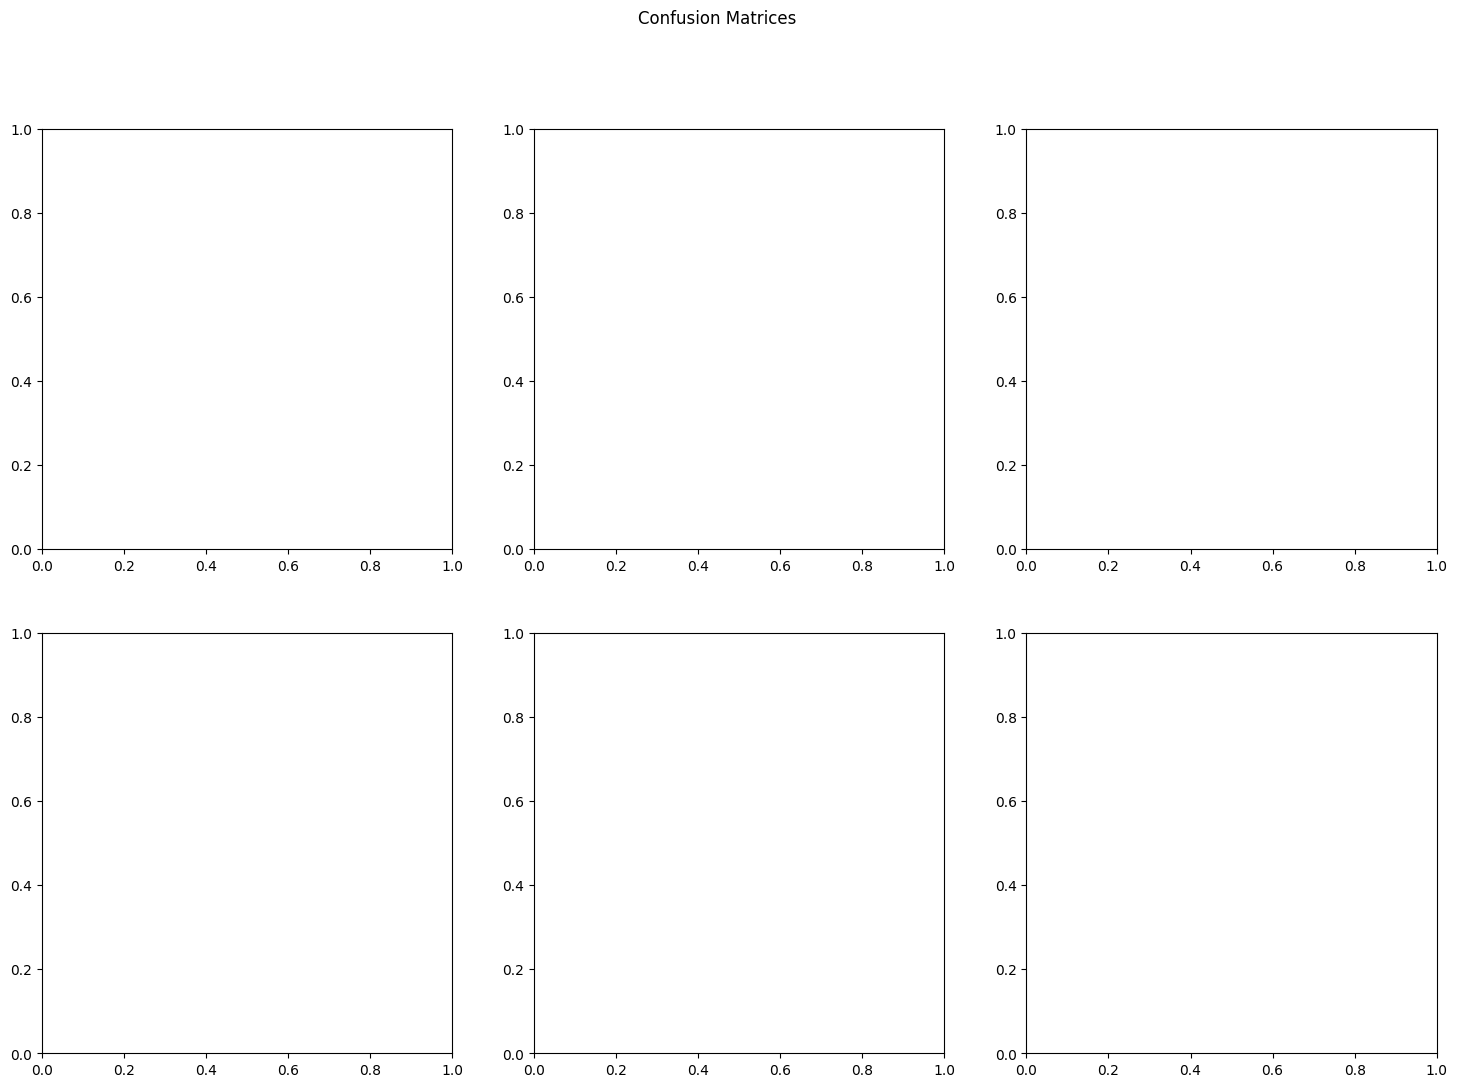

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(ax, df, true_labels_column, predicted_labels_column,
                          title=None
                          ):
    predicted_labels = df[f'{predicted_labels_column}']
    true_labels = df[f'{true_labels_column}']

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)


    # Display confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True,
                yticklabels=True, ax=ax)

    title = title if title else predicted_labels_column

    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices')

# Plot each confusion matrix
plot_confusion_matrix(axes[0, 0], df_merge, 'label', '0_shot_label', '0_shot')
plot_confusion_matrix(axes[0, 1], df_merge, 'label',
                      '0_shot_with_system_label', '0_shot_with_system')
plot_confusion_matrix(axes[0, 2], df_merge, 'label', '0_shot_cot_label',
                      '0_shot_cot')
plot_confusion_matrix(axes[1, 0], df_merge, 'label', '2_shot_label', '2_shot')
plot_confusion_matrix(axes[1, 1], df_merge, 'label', '4_shot_label', '4_shot')
plot_confusion_matrix(axes[1, 2], df_merge, 'label', '8_shot_label', '8_shot')

plt.tight_layout(
    rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
plt.show()

# Krippendorff Alpha in model

In [ ]:
import krippendorff

runs = ['0_shot_label', '0_shot_with_system_label', '0_shot_cot_label',
        '2_shot_label', '4_shot_label', '8_shot_label']


def compute_krippendorff_alpha(df, predicted_columns):
    pred_map = {}
    for run in predicted_columns:
        predicted_labels = df[run]
        pred_map[run] = predicted_labels

    # Check if there is variability in the ratings
    unique_labels_counts = df[predicted_columns].nunique(axis=1)
    if unique_labels_counts.max() == 1:
        # All ratings are the same, return a special value or handle accordingly
        return 0

    reliability_data = df[predicted_columns].values.tolist()

    # Calculate Krippendorff's alpha
    alpha = krippendorff.alpha(reliability_data=list(pred_map.values()),
                               level_of_measurement='nominal')

    return alpha


In [ ]:
alpha_value = compute_krippendorff_alpha(df_merge, runs)
print(f"Krippendorff's Alpha (all runs): {alpha_value}")

In [ ]:
import itertools

def compute_krippendorff_alpha_for_k_runs(df, runs, k=None):
    # Initialize variables to store the best combination and alpha
    if k is None:
        k = len(runs)

    best_combination = None
    best_alpha = 0  # Assuming alpha ranges from 0 to 1

    # Iterate through all possible combinations
    for combination in itertools.combinations(runs, k):

        alpha_value = compute_krippendorff_alpha(df, list(combination))

        # Print alpha for the current combination
        print(f"Combination: {combination}, Alpha: {alpha_value}")

        # Update best combination and alpha if a higher alpha is found
        if alpha_value > best_alpha:
            best_alpha = alpha_value
            best_combination = combination

    # Print the best combination and alpha
    print(f"\nBest Combination: {best_combination}, Best Alpha: {best_alpha}")
    return best_alpha, best_combination

In [ ]:
compute_krippendorff_alpha_for_k_runs(df_merge, runs, 2)